# EDA-3

## 1. 导入数据 

In [101]:
import pandas as pd
import numpy as np

In [78]:
df=pd.read_csv("../../data/终版数据/cleaned_customer.csv")

In [80]:
df.shape

(155250, 60)

In [81]:
df.head(2)

,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,host_since,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,nearby_sites_rating,nearest_station_dist,nearest_site_dist,nearest_site_rating
0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,2010-10-20,...,10.0,8.0,8.0,f,2,0.02,0.995731,0.617762,4.295315,4.595264
1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,2010-09-08,...,10.0,9.0,9.0,f,1,0.30,1.269606,0.399696,2.039236,4.654423


##  2. 处理特征

###  2.1 高回复率 host_response_rate

#### 初探索 

In [88]:
df.host_response_rate.dtype

dtype('O')

In [89]:
df.host_response_rate.isnull().value_counts()

False    149070
True       6180
Name: host_response_rate, dtype: int64

In [92]:
df.host_response_rate.value_counts().head()

100%    96426
99%      9699
97%      6725
98%      6659
86%      3521
Name: host_response_rate, dtype: int64

首先，我们需要把所有的比例从当前的字符串转化为小数。里面的缺失值需要drop掉。

#### 舍弃这列的缺失值 

In [91]:
df.dropna(subset=["host_response_rate"],inplace=True)

In [93]:
df.shape

(149070, 60)

#### 改变字符串类型并转化为小数

In [94]:
df.host_response_rate = df.host_response_rate.apply(lambda x: int(x[:-1])/100)

In [95]:
df.host_response_rate.dtype

dtype('float64')

### 2.2 回复速度 host_response_time 

#### 初探索 

In [96]:
df.host_response_time.isnull().value_counts()

False    149070
Name: host_response_time, dtype: int64

现在发现没有空值，原因在于host_responce_time和host_response_rate是同时缺失。

我们之前已经删除了host_response_rate的缺失值，所以此时这个特征host_responce_time已经没有缺失值了

In [97]:
df.host_response_time.value_counts()

within an hour        115193
within a few hours     26529
within a day            6413
a few days or more       935
Name: host_response_time, dtype: int64

因此，我们需要把这四类改变成四个数字：回复时间越短，分数越高

   - "within an hour": 4      
   - "within a few hours": 3
   - "within a day": 2 
   - "a few days or more": 1

#### 将字符串替换为数字

In [98]:
df["host_response_time"].replace({"within an hour": 4,
                                  "within a few hours": 3,
                                  "within a day": 2, 
                                  "a few days or more": 1
                                  }, inplace=True)

In [99]:
df.host_response_time.value_counts()

4    115193
3     26529
2      6413
1       935
Name: host_response_time, dtype: int64

### 2.3 客户评论的分数 review_average_score

我们需要对客户的评论做sentimental analysis，从而得到一个分数来表示客户的喜爱度

#### 初探索 

In [106]:
df.comments.isnull().value_counts()

False    148900
True        170
Name: comments, dtype: int64

#### 删除comments的空值

In [107]:
df.dropna(subset=["comments"],inplace=True)

In [108]:
df.shape

(148900, 60)

#### 利用Afinn来计算分数

In [102]:
from afinn import Afinn

In [103]:
afinn = Afinn()

In [109]:
df["sentiment_score"]=df.comments.apply(lambda x: afinn.score(x))

In [116]:
df.sentiment_score.describe()

count    148900.000000
mean          6.836373
std           6.951351
min         -62.000000
25%           2.000000
50%           6.000000
75%          10.000000
max         131.000000
Name: sentiment_score, dtype: float64

In [117]:
df.sentiment_score.value_counts()

 0.0      26832
 3.0      16431
 5.0      10559
 6.0       9956
 7.0       8223
          ...  
-33.0         1
 68.0         1
 77.0         1
-61.0         1
 131.0        1
Name: sentiment_score, Length: 116, dtype: int64

In [125]:
import matplotlib.pyplot as plt

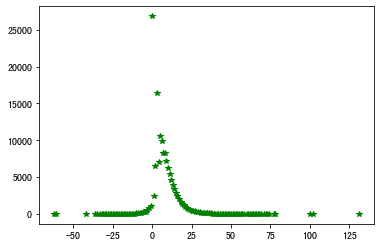

In [127]:
pyplot.plot(df.sentiment_score.value_counts(),"g*")
plt.show()

### 2.4 feature cross 特征交叉 

将 回复速度 host_response_time 和 高回复率 host_response_rate 进行特征交叉

交叉方式：host_response_time * host_response_rate

**分数结果越高越好**

In [120]:
df["response_score"]=df.host_response_time*df.host_response_rate

In [123]:
df.response_score.value_counts()

4.00    82301
3.00    12405
3.96     8969
3.92     6155
3.88     5568
        ...  
1.16        1
1.52        1
1.74        1
1.04        1
0.09        1
Name: response_score, Length: 158, dtype: int64

## 3. 探索问题 

#### 利用散点图

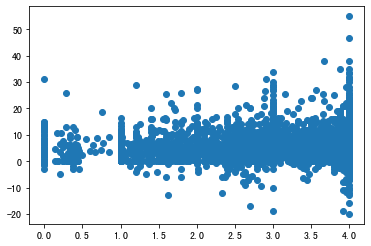

In [149]:
plt.scatter(df3.response_score,
            df3.sentiment_score)
plt.show()

In [150]:
np.corrcoef(df3.response_score,
            df3.sentiment_score)

array([[1.        , 0.05252775],
       [0.05252775, 1.        ]])

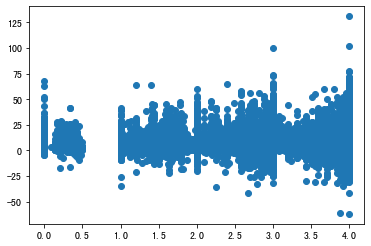

In [151]:
plt.scatter(df.response_score,
            df.sentiment_score)

plt.show()

In [152]:
np.corrcoef(df.sentiment_score,df.response_score)

array([[ 1.        , -0.04006338],
       [-0.04006338,  1.        ]])

#### 把sentimental score合并，从房屋的视角出发

In [140]:
df2=df[["listing_id","response_score","sentiment_score"]]
df2

,listing_id,response_score,sentiment_score
0,49091,3.0,10.0
19,56334,3.0,8.0
20,56334,3.0,9.0
21,56334,3.0,7.0
22,56334,3.0,8.0
...,...,...,...
155245,46164107,4.0,3.0
155246,46164107,4.0,0.0
155247,46164107,4.0,3.0
155248,46420476,4.0,0.0


In [142]:
df3= pd.pivot_table(df2,
                    index=["listing_id"],
                    values=["response_score","sentiment_score"]
                   )

In [153]:
df3

,response_score,sentiment_score
listing_id,,
49091,3.000000,10.000000
56334,3.000000,13.900000
71609,3.947368,5.631579
71896,4.000000,8.318182
71903,3.933333,6.688889
...,...,...
46569412,3.960000,10.000000
46590657,3.840000,2.000000
46682651,3.960000,4.000000
